# **Classificação de Redes Complexas**

**Objetivo**

Avaliar três redes de cada tipo (biológica, social e tecnológica) selecionadas de repositórios online e verificar, por meio de medidas de redes e geração de modelos nulos (Erdős–Rényi, Watts–Strogatz, Barabási–Albert, Waxman), qual modelo melhor descreve cada rede real. Projeta-se os vetores de características em 2D via PCA e aplica-se um classificador para testar a hipótese de que redes de mesmo tipo seguem o mesmo modelo.

## **1. Seleção das redes**

| Tipo        | Nome/Descrição | Fonte                                                           |
| ----------- | -------------- | --------------------------------------------------------------- | 
| Biológica   |                | ICON (formigas-brain.txt)                                       |   
| Biológica   |                | ICON (gatos-brain.txt)                                          |   
| Biológica   |                | ICON (ratos-brain.txt)                                          |   
| Social      |                | ICON (associacao-ceo-club.txt)                                  |   
| Social      |                | ICON (redes-marvel.txt)                                         |   
| Social      |                | ICON (dominancia-bison.txt)                                     |   
| Tecnológica |                | ICON (grafico-caida-as.txt)                                     |  
| Tecnológica |                | ICON (rede-eletrica-eua.txt)                                    |   
| Tecnológica |                | ICON (rede-gnutella.txt)                                        |  

<br>

> **Ação**: fizemos o download de cada grafo em formato txt (`.txt`),

## **2. Medidas das redes reais**

Para cada rede real, calculamos:

1. **Distribuição de graus** (histograma + média e desvio‑padrão).
2. **Coeficiente de agrupamento global** (clustering coefficient).
3. **Comprimento médio de caminho** (caminho geodésico médio).
4. **Assortatividade de grau**.
5. **Diâmetro**.
6. **Distribuição de comprimentos de caminho**.

Armazenamos os resultados em um `pandas.DataFrame`.

In [19]:
import networkx as nx
import numpy as np
import pandas as pd
import logging
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import time
from networkx import gnp_random_graph, watts_strogatz_graph, barabasi_albert_graph
from networkx.generators.geometric import waxman_graph
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency, fisher_exact
import matplotlib.pyplot as plt

# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [20]:
# Função para carregar o grafo
def carrega_grafo(arquivo):
    G = None
    try:
        logging.info(f"Carregando arquivo {arquivo}...")
        edges = []
        # Carregando arestas para diferentes tipos de redes
        if arquivo.startswith('1'):  # Redes sociais
            with open(arquivo, 'r') as f:
                for line in f:
                    nodes = line.split()
                    if len(nodes) == 2:
                        edges.append((nodes[0], nodes[1]))
            G = nx.Graph()
            G.add_edges_from(edges)
        elif arquivo.startswith('2'):  # Redes biológicas
            G = nx.read_edgelist(arquivo, nodetype=str)
            G = nx.relabel_nodes(G, lambda x: x[1:] if x[0] == 'n' else x)
        elif arquivo.startswith('3'):  # Redes tecnológicas
            with open(arquivo, 'r') as f:
                for line in f:
                    nodes = line.split()
                    if len(nodes) == 2:
                        edges.append((nodes[0], nodes[1]))
            G = nx.Graph()
            G.add_edges_from(edges)
        
        if G:
            logging.info(f"Arquivo {arquivo} carregado com sucesso.")
        else:
            logging.error(f"Falha ao carregar o arquivo {arquivo}!")
        return G
    except Exception as e:
        logging.error(f"Erro ao processar o arquivo {arquivo}: {e}")
        return None

In [21]:
# Função para extrair métricas de uma rede
def extrai_medidas(G):
    n = G.number_of_nodes()
    
    if n == 0:
        return {
            'N': n,
            'kbar': np.nan,
            'deg_std': np.nan,
            'C': np.nan,
            'L': np.nan,
            'r': np.nan,
            'd': np.nan
        }
    
    kbar = sum(dict(G.degree()).values()) / n
    degs = np.array(list(dict(G.degree()).values()))
    C = nx.transitivity(G)
    
    if nx.is_connected(G):
        L = nx.average_shortest_path_length(G)
        d = nx.diameter(G)
    else:
        L, d = np.nan, np.nan  # Grafo desconexo: não podemos calcular o comprimento médio ou o diâmetro
    
    r = nx.degree_assortativity_coefficient(G)
    
    return {
        'N': n,
        'kbar': kbar,
        'deg_std': degs.std() if n > 1 else np.nan,
        'C': C,
        'L': L,
        'r': r,
        'd': d
    }

## **3. Geração de modelos nulos**

Para cada rede real com parâmetros $N,\bar{k}$, gere quatro modelos:

| Modelo               | Parâmetros                                             |
| -------------------- | ------------------------------------------------------ |
| ER (Erdős–Rényi)     | `n=N`, `p=\bar{k}/(N-1)`                               |
| WS (Watts–Strogatz)  | `n=N`, `k=round(\bar{k})` (par), `p_rewire=0.1`        |
| BA (Barabási–Albert) | `n=N`, `m=round(\bar{k}/2)`                            |
| Waxman               | `n=N`, `alpha=0.4`, `beta=0.1` (ajustar se necessário) |

In [22]:
# Função para gerar modelos nulos
def gera_modelos(N, kbar):
    m = max(1, int(round(kbar / 2)))
    return {
        'ER': nx.gnp_random_graph(N, kbar / (N - 1)),
        'WS': nx.watts_strogatz_graph(N, round(kbar), p=0.1),
        'BA': nx.barabasi_albert_graph(N, m),
        'WX': nx.waxman_graph(N, alpha=0.4, beta=0.1)
    }

In [23]:
# Função para calcular as métricas de uma rede
def calcula_metricas_para_modelo(row):
    # Início do processo de geração de modelos nulos
    logging.debug(f"Iniciando a geração de modelos nulos para a rede: {row['id']}")
    
    N = row['N']
    kbar = row['kbar']
    
    # Geração dos modelos nulos com os parâmetros N e kbar
    modelos = gera_modelos(N, kbar)
    
    modelos_nulos = []
    for modelo, G in modelos.items():
        # Extração das métricas do modelo
        medidas = extrai_medidas(G)
        
        # Adicionando as métricas ao resultado final
        modelos_nulos.append({
            'id': row['id'],
            'modelo': modelo,
            'tipo': row['tipo'],
            **medidas
        })
    
    # Log de finalização do processo
    logging.debug(f"Finalizada a geração de modelos nulos para a rede: {row['id']}")
    
    return modelos_nulos


In [24]:
import networkx as nx

# Função para gerar modelos nulos
def gera_modelos(N, kbar):
    m = max(1, int(round(kbar / 2)))
    return {
        'ER': nx.gnp_random_graph(N, kbar / (N - 1)),
        'WS': nx.watts_strogatz_graph(N, round(kbar), p=0.1),
        'BA': nx.barabasi_albert_graph(N, m),
        'WX': nx.waxman_graph(N, alpha=0.4, beta=0.1)
    }


In [25]:
# Função para processar os arquivos
def processa_arquivos(arquivos):
    resultados = []
    for arquivo in arquivos:
        G = carrega_grafo(arquivo)
        if G:
            medidas = extrai_medidas(G)
            tipo = 'Social' if arquivo.startswith('1') else ('Biológica' if arquivo.startswith('2') else 'Tecnológica')
            resultados.append({'id': arquivo, 'tipo': tipo, **medidas})
    return pd.DataFrame(resultados)

In [26]:
import time
from concurrent.futures import ProcessPoolExecutor
import logging
import pandas as pd
from tqdm import tqdm

# Função para carregar arquivos de um tipo específico
def processa_arquivos_por_tipo(arquivos, tipo):
    resultados = []
    
    # Usar ProcessPoolExecutor para carregar e processar os arquivos em paralelo
    with ProcessPoolExecutor(max_workers=4) as executor:  # Usando 4 workers para aproveitar mais núcleos
        futures = list(executor.map(carrega_grafo, arquivos))  # Usando map diretamente
        
        for arquivo, G in zip(arquivos, futures):
            try:
                if G:
                    medidas = extrai_medidas(G)
                    resultados.append({'id': arquivo, 'tipo': tipo, **medidas})
                else:
                    logging.warning(f"Arquivo {arquivo} não foi carregado corretamente.")
            except Exception as e:
                logging.error(f"Erro ao processar o arquivo {arquivo}. Tipo de erro: {type(e).__name__}. Detalhes: {e}")
                continue
    return pd.DataFrame(resultados)

# Lista de arquivos por tipo
arquivos_sociais = ['1associacao-ceo-club.txt', '1advogato.txt', '1redes-marvel.txt']
arquivos_biologicos = ['2formigas-brain.txt', '2gatos-brain.txt', '2ratos-brain.txt']
arquivos_tecnologicos = ['3lesmis.txt', '3rede-eletrica-eua.txt', '3rede-gnutella.txt']

# Processando os arquivos sociais
logging.info("Iniciando o processamento dos arquivos sociais...")
start_time = time.time()
df_sociais = processa_arquivos_por_tipo(arquivos_sociais, 'Social')
elapsed_time = time.time() - start_time
logging.info(f"Tempo para processar arquivos sociais: {elapsed_time:.2f} segundos.")

# Processando os arquivos biológicos
logging.info("Iniciando o processamento dos arquivos biológicos...")
start_time = time.time()
df_biologicos = processa_arquivos_por_tipo(arquivos_biologicos, 'Biológica')
elapsed_time = time.time() - start_time
logging.info(f"Tempo para processar arquivos biológicos: {elapsed_time:.2f} segundos.")

# Processando os arquivos tecnológicos
logging.info("Iniciando o processamento dos arquivos tecnológicos...")
start_time = time.time()
df_tecnologicos = processa_arquivos_por_tipo(arquivos_tecnologicos, 'Tecnológica')
elapsed_time = time.time() - start_time
logging.info(f"Tempo para processar arquivos tecnológicos: {elapsed_time:.2f} segundos.")



2025-05-10 18:41:48,747 - Iniciando o processamento dos arquivos sociais...
2025-05-10 18:41:48,824 - Carregando arquivo 1associacao-ceo-club.txt...
2025-05-10 18:41:48,828 - Carregando arquivo 1advogato.txt...
2025-05-10 18:41:48,846 - Arquivo 1associacao-ceo-club.txt carregado com sucesso.
2025-05-10 18:41:48,846 - Carregando arquivo 1redes-marvel.txt...
2025-05-10 18:41:49,127 - Arquivo 1redes-marvel.txt carregado com sucesso.
2025-05-10 18:41:49,208 - Arquivo 1advogato.txt carregado com sucesso.
2025-05-10 18:41:50,405 - Tempo para processar arquivos sociais: 1.66 segundos.
2025-05-10 18:41:50,406 - Iniciando o processamento dos arquivos biológicos...
2025-05-10 18:41:50,448 - Carregando arquivo 2ratos-brain.txt...
2025-05-10 18:41:50,447 - Carregando arquivo 2formigas-brain.txt...
2025-05-10 18:41:50,447 - Carregando arquivo 2gatos-brain.txt...
2025-05-10 18:41:50,458 - Arquivo 2formigas-brain.txt carregado com sucesso.
2025-05-10 18:41:50,525 - Arquivo 2gatos-brain.txt carregado 

In [28]:
import logging
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pandas as pd
from multiprocessing import cpu_count

# Configuração do logging para garantir que os logs sejam exibidos corretamente
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()  # Criando o logger

# Concatenando todos os DataFrames de forma mais eficiente
logger.info("Iniciando a concatenação dos DataFrames...")

df_completo = pd.concat([df_sociais, df_biologicos, df_tecnologicos], ignore_index=True)

# Selecionar uma amostra aleatória de 50% dos dados para testar
logger.info("Iniciando a seleção da amostra aleatória de 10% dos dados.")
df_amostra = df_completo.sample(frac=0.1, random_state=42)  # Teste com 10% dos dados
logger.info(f"Amostra selecionada com {len(df_amostra)} registros.")

# Verificando o tamanho da amostra
logger.info(f"Tamanho da amostra para o cálculo: {len(df_amostra)} registros")

# Função para calcular as métricas de uma rede
def calcula_metricas_para_modelo(row):
    logger.debug(f"Iniciando a geração de modelos nulos para a rede: {row['id']}")
    
    N = row['N']
    kbar = row['kbar']
    
    # Gerar modelos nulos com os parâmetros N e kbar da rede
    logger.debug(f"Gerando modelos nulos com N={N} e kbar={kbar} para a rede: {row['id']}")
    modelos = gera_modelos(N, kbar)
    logger.debug(f"Modelos nulos gerados para a rede: {row['id']}")
    
    modelos_nulos = []
    for modelo, G in modelos.items():
        logger.debug(f"Extraindo medidas para o modelo {modelo} da rede: {row['id']}")
        medidas = extrai_medidas(G)
        modelos_nulos.append({
            'id': row['id'],
            'modelo': modelo,
            'tipo': row['tipo'],
            **medidas
        })
    
    logger.debug(f"Finalizada a geração de modelos nulos para a rede: {row['id']}")
    return modelos_nulos

# Teste do código sem ProcessPoolExecutor (processamento sequencial)
logger.info("Iniciando o processamento sequencial das redes...")
start_time = time.time()

modelos_nulos = []
for idx, row in df_amostra.iterrows():
    resultado = calcula_metricas_para_modelo(row)
    modelos_nulos.extend(resultado)

logger.info(f"Processamento sequencial concluído. Total de {len(modelos_nulos)} modelos nulos gerados.")

# Criar DataFrame com os modelos nulos
logger.info(f"Gerando DataFrame com {len(modelos_nulos)} modelos nulos.")
df_modelos_nulos = pd.DataFrame(modelos_nulos)

# Concatenar os modelos nulos ao DataFrame original
logger.info(f"Concatenando os modelos nulos ao DataFrame original.")
df_completo = pd.concat([df_amostra, df_modelos_nulos])

# Exibir as primeiras linhas para verificar
logger.info(f"Modelos nulos gerados e concatenados. Total de {len(df_modelos_nulos)} modelos nulos.")
print(df_completo.head())

# Calcular o tempo gasto para gerar modelos nulos
elapsed_time = time.time() - start_time
logger.info(f"Tempo para gerar e adicionar os modelos nulos ao DataFrame (sequencial): {elapsed_time:.2f} segundos.")

2025-05-10 18:48:54,263 - Iniciando a concatenação dos DataFrames...
2025-05-10 18:48:54,267 - Iniciando a seleção da amostra aleatória de 10% dos dados.
2025-05-10 18:48:54,270 - Amostra selecionada com 1 registros.
2025-05-10 18:48:54,272 - Tamanho da amostra para o cálculo: 1 registros
2025-05-10 18:48:54,274 - Iniciando o processamento sequencial das redes...
2025-05-10 18:50:45,342 - Processamento sequencial concluído. Total de 4 modelos nulos gerados.
2025-05-10 18:50:45,344 - Gerando DataFrame com 4 modelos nulos.
2025-05-10 18:50:45,346 - Concatenando os modelos nulos ao DataFrame original.
2025-05-10 18:50:45,351 - Modelos nulos gerados e concatenados. Total de 4 modelos nulos.
2025-05-10 18:50:45,362 - Tempo para gerar e adicionar os modelos nulos ao DataFrame (sequencial): 111.09 segundos.


                       id         tipo     N        kbar    deg_std         C  \
7  3rede-eletrica-eua.txt  Tecnológica  4941    2.669095   1.791272  0.103153   
0  3rede-eletrica-eua.txt  Tecnológica  4941    2.686096   1.617811  0.000340   
1  3rede-eletrica-eua.txt  Tecnológica  4941    2.000000   0.436171  0.000000   
2  3rede-eletrica-eua.txt  Tecnológica  4941    1.999595   3.700375  0.000000   
3  3rede-eletrica-eua.txt  Tecnológica  4941  211.340215  29.496219  0.045708   

            L         r      d modelo  
7   18.989185  0.003457   46.0    NaN  
0         NaN  0.004201    NaN     ER  
1  153.038713 -0.024895  388.0     WS  
2    8.292929 -0.061437   21.0     BA  
3    1.957709  0.058155    3.0     WX  


In [29]:
# Caso o sequencial funcione, agora testamos o paralelismo.
logger.info("Iniciando a geração dos modelos nulos para as redes reais com ProcessPoolExecutor...")

start_time_parallel = time.time()

modelos_nulos_parallel = []
max_workers = cpu_count()  # Usando o número de CPUs disponíveis

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    resultados = []
    for resultado in tqdm(executor.map(calcula_metricas_para_modelo, [row for idx, row in df_amostra.iterrows()]), total=len(df_amostra)):
        resultados.append(resultado)
    
    logger.debug(f"Processamento paralelo concluído. Total de {len(resultados)} resultados obtidos.")
    for resultado in resultados:
        modelos_nulos_parallel.extend(resultado)

# Criar DataFrame com os modelos nulos
logger.info(f"Gerando DataFrame com {len(modelos_nulos_parallel)} modelos nulos gerados no processamento paralelo.")
df_modelos_nulos_parallel = pd.DataFrame(modelos_nulos_parallel)

# Concatenar os modelos nulos ao DataFrame original
logger.info(f"Concatenando os modelos nulos ao DataFrame original.")
df_completo_parallel = pd.concat([df_amostra, df_modelos_nulos_parallel])

# Exibir as primeiras linhas para verificar
logger.info(f"Modelos nulos gerados e concatenados. Total de {len(df_modelos_nulos_parallel)} modelos nulos.")
print(df_completo_parallel.head())

# Calcular o tempo gasto para gerar modelos nulos
elapsed_time_parallel = time.time() - start_time_parallel
logger.info(f"Tempo para gerar e adicionar os modelos nulos ao DataFrame (paralelismo): {elapsed_time_parallel:.2f} segundos.")

2025-05-10 18:51:06,609 - Iniciando a geração dos modelos nulos para as redes reais com ProcessPoolExecutor...
100%|██████████| 1/1 [01:23<00:00, 83.53s/it]
2025-05-10 18:52:30,427 - Gerando DataFrame com 4 modelos nulos gerados no processamento paralelo.
2025-05-10 18:52:30,429 - Concatenando os modelos nulos ao DataFrame original.
2025-05-10 18:52:30,432 - Modelos nulos gerados e concatenados. Total de 4 modelos nulos.
2025-05-10 18:52:30,436 - Tempo para gerar e adicionar os modelos nulos ao DataFrame (paralelismo): 83.82 segundos.


                       id         tipo     N        kbar    deg_std         C  \
7  3rede-eletrica-eua.txt  Tecnológica  4941    2.669095   1.791272  0.103153   
0  3rede-eletrica-eua.txt  Tecnológica  4941    2.640356   1.631748  0.000000   
1  3rede-eletrica-eua.txt  Tecnológica  4941    2.000000   0.423935  0.000000   
2  3rede-eletrica-eua.txt  Tecnológica  4941    1.999595   3.705513  0.000000   
3  3rede-eletrica-eua.txt  Tecnológica  4941  213.734871  29.472515  0.046047   

           L         r     d modelo  
7  18.989185  0.003457  46.0    NaN  
0        NaN -0.022857   NaN     ER  
1        NaN -0.038637   NaN     WS  
2   8.712643 -0.053891  23.0     BA  
3   1.957142  0.053119   3.0     WX  


Calculamos as mesmas métricas para cada grafo modelo.

## **4. Preparação para PCA e classificação**

1. Concatenamos as medidas de todas as redes (reais e modelos) em um `DataFrame` com colunas:

   * `id` (identificador da rede)
   * `tipo` (Biológica/Social/Tecnológica)
   * `modelo` (ER/WS/BA/WX ou "Real")
   * `N`, `kbar`, `deg_std`, `C`, `L`, `r`, `d`
2. Normalizamos com `StandardScaler`.
3. Aplicamos `PCA(n_components=2)` para reduzir a 2 dimensões.

In [31]:
import logging
import time
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Iniciando o processo de PCA para redução dimensional
logging.info("Iniciando o processo de PCA para redução dimensional...")

# Marcar o tempo de início
start_time_pca = time.time()

# Definir as variáveis de entrada (características de redes)
X = df_completo[['N', 'kbar', 'deg_std', 'C', 'L', 'r', 'd']].values

# Tratamento de valores ausentes
logging.info("Imputando valores ausentes com a média...")
imputer = SimpleImputer(strategy='mean')  # Estratégia: preencher NaN com a média
X_imputed = imputer.fit_transform(X)

# Normalização das características
logging.info("Normalizando as características...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Aplicar PCA para redução de dimensionalidade (do original 7D para 2D)
logging.info("Aplicando PCA para redução dimensional...")
pca = IncrementalPCA(n_components=2, batch_size=100)  # Usar PCA incremental para datasets grandes
# Se os dados forem pequenos, você pode usar PCA tradicional
# pca = PCA(n_components=2)

coords = pca.fit_transform(X_scaled)

# Armazenar as coordenadas dos componentes principais no DataFrame
df_completo[['PC1', 'PC2']] = coords

# Medir o tempo de execução do PCA
elapsed_time_pca = time.time() - start_time_pca
logging.info(f"Tempo para aplicar o PCA e gerar as componentes principais: {elapsed_time_pca:.2f} segundos.")


2025-05-10 18:54:38,142 - Iniciando o processo de PCA para redução dimensional...
2025-05-10 18:54:38,147 - Imputando valores ausentes com a média...
2025-05-10 18:54:38,153 - Normalizando as características...
2025-05-10 18:54:38,157 - Aplicando PCA para redução dimensional...
2025-05-10 18:54:38,164 - Tempo para aplicar o PCA e gerar as componentes principais: 0.02 segundos.


## **5. Visualização e classificação**

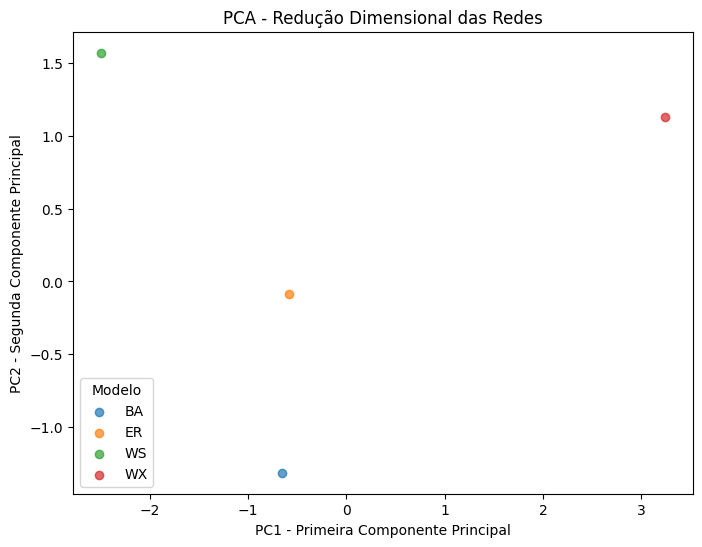

2025-05-10 18:55:10,352 - Tempo para aplicar o PCA e gerar o gráfico: 32.21 segundos.


In [32]:
import matplotlib.pyplot as plt

# Visualizar os resultados do PCA
fig, ax = plt.subplots(figsize=(8, 6))

# Verificar se as colunas PC1 e PC2 estão presentes no DataFrame
if 'PC1' in df_completo.columns and 'PC2' in df_completo.columns:
    # Separar os dados pelo modelo para colorir os pontos
    for label, grp in df_completo.groupby('modelo'):
        ax.scatter(grp['PC1'], grp['PC2'], label=label, alpha=0.7)

    # Adicionar a legenda
    ax.legend(title='Modelo')

    # Adicionar rótulos ao gráfico
    ax.set_xlabel('PC1 - Primeira Componente Principal')
    ax.set_ylabel('PC2 - Segunda Componente Principal')

    # Adicionar título
    ax.set_title('PCA - Redução Dimensional das Redes')

    # Exibir o gráfico
    plt.show()

    # Calcular o tempo gasto no PCA
    elapsed_time_pca = time.time() - start_time_pca
    logging.info(f"Tempo para aplicar o PCA e gerar o gráfico: {elapsed_time_pca:.2f} segundos.")
else:
    logging.warning("As colunas 'PC1' e 'PC2' não foram encontradas no DataFrame. Verifique os dados.")

## **6. Teste da hipótese**

**Hipótese**: redes do mesmo **tipo** seguem o mesmo **modelo**.

1. Usamos `cross_val_predict` para obter `modelo_predito` em cada amostra.
2. Montamos uma tabela de contingência (tipos vs. modelos preditos).
3. Aplicamos o teste de independência qui‑quadrado.

In [34]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import logging
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

# Configuração do logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Definir os rótulos (modelo)
y = df_completo['modelo']

# Imputação de rótulos ausentes
imputer_y = SimpleImputer(strategy='most_frequent')
y_imputed = imputer_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Verificando a distribuição dos rótulos (para ajustar a validação cruzada)
logging.info("Distribuição dos rótulos (modelo):")
logging.info(pd.Series(y_imputed).value_counts())  # Convertendo para Series pandas e chamando value_counts

# Ajuste na validação cruzada
# Verificando a distribuição das classes
n_samples = len(y_imputed)
logging.info(f"Número de amostras: {n_samples}")

# Se o número de amostras for pequeno, podemos usar LeaveOneOut ou um número maior de splits no StratifiedKFold
if n_samples <= 5:  # Exemplo de critério para uso de LeaveOneOut
    logging.info("Usando LeaveOneOut devido ao número pequeno de amostras.")
    cv = LeaveOneOut()  # Usar LeaveOneOut
else:
    logging.info("Usando StratifiedKFold com 5 splits.")
    cv = StratifiedKFold(n_splits=5)  # Usar 5 splits no StratifiedKFold

# Definir o classificador K-NN
clf = KNeighborsClassifier(n_neighbors=1)  # Mantemos 1 vizinho devido ao número de amostras pequenas

# Teste de Hipótese com validação cruzada
logging.info("Iniciando a validação cruzada e predição com K-NN...")
y_pred = cross_val_predict(clf, X_scaled, y_imputed, cv=cv)
df_completo['modelo_predito'] = y_pred

# Tabela de contingência
cont = pd.crosstab(df_completo['tipo'], df_completo['modelo_predito'])
logging.info("Tabela de contingência:")
logging.info(cont)

# Teste exato de Fisher ou Qui-Quadrado
if cont.shape[0] == 2 and cont.shape[1] == 2:
    # Usar Fisher quando a tabela for 2x2
    _, p = fisher_exact(cont)
    logging.info(f'p-valor do teste exato de Fisher: {p}')
else:
    # Quando a tabela for maior que 2x2, use o teste qui-quadrado
    chi2, p, dof, exp = chi2_contingency(cont)
    logging.info(f'p-valor do teste qui-quadrado: {p}')


2025-05-10 18:55:56,243 - Distribuição dos rótulos (modelo):
2025-05-10 18:55:56,246 - BA    2
ER    1
WS    1
WX    1
Name: count, dtype: int64
2025-05-10 18:55:56,249 - Número de amostras: 5
2025-05-10 18:55:56,251 - Usando LeaveOneOut devido ao número pequeno de amostras.
2025-05-10 18:55:56,252 - Iniciando a validação cruzada e predição com K-NN...
2025-05-10 18:55:56,289 - Tabela de contingência:
2025-05-10 18:55:56,293 - modelo_predito  BA  ER
tipo                  
Tecnológica      2   3
2025-05-10 18:55:56,303 - p-valor do teste qui-quadrado: 1.0
